In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import tensorflow as tf
from tensorflow import keras

house_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
train_labels = house_data["SalePrice"].copy()
train_data = house_data.copy()
train_data.drop(columns="SalePrice")



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


Columns contain mixture of categorical data and numerical data, these will require different preprocessing. We have:
* Numerical data: This needs to be scaled between 0 and 1.
* Categorical data (including the zoning code!): This needs to be one-hot encoded.
* 'Quality' categories: This needs to be converted to an equal numeric range between 0 and 1.

Missing values must also be managed:
* For numerical columns, exclude all NA rows to find the mean, then replace NA with the mean wherever it appears
* For categorical columns, NA will be included as a category
* Neither the training data nor test data contains any nulls (but if they were there then they should be replaced with NA first, then subjected to the same processing.

All these steps must be performed on the training data and validation data separately after splitting them! (wrap in function to take each) otherwise replacement with the mean of the whole dataset would lead to information leakage between train and validation sets.

In [3]:
def quality_preprocess(data):
    lotshapeencode = {"Reg":0, "IR1":1, "IR2":2, "IR3":3}
    data["LotShape"] = data["LotShape"].replace(lotshapeencode)
    landslopeencode = {"Gtl":0, "Mod":1, "Sev":2}
    data["LandSlope"] = data["LandSlope"].replace(landslopeencode)
    qualcondencode = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "NA":0}
    data["ExterQual"] = data["ExterQual"].replace(qualcondencode)
    data["ExterCond"] = data["ExterCond"].replace(qualcondencode)
    data["BsmtQual"] = data["BsmtQual"].replace(qualcondencode)
    data["BsmtCond"] = data["BsmtCond"].replace(qualcondencode)
    exposureencode = {"Gd":3, "Av":2, "Mn":1, "No":0}
    data["BsmtExposure"] = data["BsmtExposure"].replace(exposureencode)
    data["HeatingQC"] = data["HeatingQC"].replace(qualcondencode)
    data["KitchenQual"] = data["KitchenQual"].replace(qualcondencode)
    functionalencode = {"Typ":7, "Min1":6, "Min2":5, "Mod":4, "Maj1":3, "Maj2":2, "Sev":1, "Sal":0}
    data["Functional"] = data["Functional"].replace(functionalencode)
    data["FireplaceQu"] = data["FireplaceQu"].replace(qualcondencode)
    finishencode = {"Fin":2, "RFn":1, "Unf":0}
    data["GarageFinish"] = data["GarageFinish"].replace(finishencode)
    data["GarageQual"] = data["GarageQual"].replace(qualcondencode)
    data["GarageCond"] = data["GarageCond"].replace(qualcondencode)
    poolencode = {"Ex":4, "Gd":3, "TA":2, "Fa":1, "NA":0}
    data["PoolQC"] = data["PoolQC"].replace(poolencode)
    fenceencode = {"GdPrv":4, "MnPrv":3, "GdWo":2, "MnWw":1, "NA":0}
    data["Fence"] = data["Fence"].replace(fenceencode)
    data["DateSold"] = data["YrSold"] + (data["MoSold"] / 12)
    data.drop(columns=["YrSold", "MoSold"])
    return data


Define which columns should be categorical, and which should be numerical

In [4]:
categorical_features = [
    "MSSubClass",
    "MSZoning",
    "Street",
    "Alley",
    "LandContour",
    "Utilities",
    "LotConfig",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "Foundation",
    "BsmtFinType1",
    "BsmtFinType2",
    "Heating",
    "CentralAir",
    "Electrical",
    "GarageType",
    "PavedDrive",
    "MiscFeature",
    "SaleType",
    "SaleCondition"
]

numerical_features = [
    "LotFrontage",
    "LotArea",
    "LotShape",
    "LandSlope",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "HeatingQC",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "KitchenQual",
    "TotRmsAbvGrd",
    "Functional",
    "Fireplaces",
    "FireplaceQu",
    "GarageYrBlt",
    "GarageFinish",
    "GarageCars",
    "GarageArea",
    "GarageQual",
    "GarageCond",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "PoolQC",
    "Fence",
    "MiscVal",
    "DateSold"
]

assert len(categorical_features) + len(numerical_features) == 78

Write preprocess instructions for categorical features, and loop for numerical features

In [5]:
def one_hot_feature(data, feature, featlist):
    if feature in data:
        one_hot = pd.get_dummies(data[feature])
        for feat in featlist:
            if feat not in one_hot.keys():
                one_hot[feat] = 0
        newnames = []
        for feat in featlist:
            newname = feature + '.' + feat
            newnames.append(newname)
        rename_dict = dict(zip(featlist, newnames))
        one_hot = one_hot.rename(columns = rename_dict)
        data = data.drop(columns = feature)
        data = data.join(one_hot)
    return data

def categorical_preprocess(data):
    subclasslist = ["20","30","40","45","50","60","70","75","80","85","90","120","150","160","180","190"]
    data = one_hot_feature(data, "MSSubClass", subclasslist)
    zoninglist = ['A', 'C (all)','FV','I','RH','RL','RP','RM']
    data = one_hot_feature(data, "MSZoning", zoninglist)
    streetlist = ['Grvl','Pave']
    data = one_hot_feature(data, "Street", streetlist)
    alleylist = ['Grvl','Pave','NA']
    data = one_hot_feature(data, "Alley", alleylist)
    contourlist = ['Lvl','Bnk','HLS','Low']
    data = one_hot_feature(data, "LandContour", contourlist)
    utilitieslist = ['AllPub', 'NoSewr', 'NoSeWa', 'ELO']
    data = one_hot_feature(data, "Utilities", utilitieslist)
    lotconfiglist = ['Inside','Corner','CulDSac','FR2','FR3']
    data = one_hot_feature(data, "LotConfig", lotconfiglist)
    neighborhoodlist = [
        'Blmngtn',
        'Blueste',
        'BrDale',
        'BrkSide',
        'ClearCr',
        'CollgCr',
        'Crawfor',
        'Edwards',
        'Gilbert',
        'IDOTRR',
        'MeadowV',
        'Mitchel',
        'Names',
        'NoRidge',
        'NPkVill',
        'NridgHt',
        'NWAmes',
        'OldTown',
        'SWISU',
        'Sawyer',
        'SawyerW',
        'Somerst',
        'StoneBr',
        'Timber',
        'Veenker'
    ]
    data = one_hot_feature(data, "Neighborhood", neighborhoodlist)
    conditionlist = ['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe']
    data = one_hot_feature(data, "Condition1", conditionlist)
    data = one_hot_feature(data, "Condition2", conditionlist)
    bldgtypelist = ['1Fam','2FmCon','Duplx','TwnhsE','TwnhsI']
    data = one_hot_feature(data, "BldgType", bldgtypelist)
    housestylelist = ['1Story','1.5Fin','1.5Unf','2Story','2.5Fin','2.5Unf','SFoyer','SLvl']
    data = one_hot_feature(data, "HouseStyle", housestylelist)
    roofstylelist = ['Flat','Gable','Gambrel','Hip','Mansard','Shed']
    data = one_hot_feature(data, "RoofStyle", roofstylelist)
    roofmatllist = ['ClyTile','CompShg','Membran','Metal','Roll','Tar&Grv','WdShake','WdShngl']
    data = one_hot_feature(data, "RoofMatl", roofmatllist)
    exteriorlist = [
        'AsbShng',
        'AsphShn',
        'BrkFace',
        'BrkComm',
        'CBlock',
        'CemntBd',
        'HdBoard',
        'ImStucc',
        'MetalSd',
        'Other',
        'Plywood',
        'PreCast',
        'Stone',
        'Stucco',
        'VinylSd',
        'Wd Sdng',
        'WdShing'
    ]
    data = one_hot_feature(data, "Exterior1st", exteriorlist)
    data = one_hot_feature(data, "Exterior2nd", exteriorlist)
    masvnrtypelist = ['BrkCmn','BrkFace','CBlock','None','Stone']
    data = one_hot_feature(data, "MasVnrType", masvnrtypelist)
    foundationlist = ["BrkTil",'Cblock','PConc','Slab','Stone','Wood']
    data = one_hot_feature(data, "Foundation", foundationlist)
    bsmtfinlist = ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA']
    data = one_hot_feature(data, "BsmtFinType1", bsmtfinlist)
    data = one_hot_feature(data, "BsmtFinType2", bsmtfinlist)
    heatinglist = ['Floor','GasA','GasW','Grav','OthW','Wall']
    data = one_hot_feature(data, "Heating", heatinglist)
    centralairlist = ['N','Y']
    data = one_hot_feature(data, "CentralAir", centralairlist)
    electricallist = ['SBrkr','FuseA','FuseF','FuseP','Mix']
    data = one_hot_feature(data, "Electrical", electricallist)
    garagelist = ['2Types','Attchd','Basement','BuiltIn','CarPort','Detchd','NA']
    data = one_hot_feature(data, "GarageType", garagelist)
    paveddrivelist = ['Y','N','P']
    data = one_hot_feature(data, "PavedDrive", paveddrivelist)
    misclist = ['Elev','Gar2','Othr','Shed','TenC','NA']
    data = one_hot_feature(data, "MiscFeature", misclist)
    saletypelist = ['WD','CWD','VWD','New','COD','Con','ConLw','ConLI','ConLD','Oth']
    data = one_hot_feature(data, "SaleType", saletypelist)
    saleconditionlist = ['Normal','Abnorml','AdjLand','Alloca','Family','Partial']
    data = one_hot_feature(data, "SaleCondition", saleconditionlist)
    return data

def normalise_preprocess(data):
    for feature in numerical_features:
        data[feature] = data[feature].replace({"NA":pd.NA})
        mean = data[feature].mean()
        data[feature] = data[feature].fillna(mean)
        stddev = data[feature].std()
        data[feature] = data[feature].sub(mean)
        data[feature] = data[feature].div(stddev)
    data = data.astype("float64")
    return data



Features must be tested for relevance: numerical data must be tested by pearson coefficient (pandas df.corr(method='pearson')), ordinal categorical data (which will be numbers) tested by spearman's rank coefficient (pandas df.corr(method='spearman'))

non-ordered categorical data will be tested by stdev of means / mean of stdevs of the sale price for each category in the field (unless i can find a better clustering metric on the internet)
if that doesn't work, then after one-hot encoding i will just find the stddev of the sales inside the category and divide the stddev of the whole set by that to drop individual one-hot encodes

In [6]:

house_data = quality_preprocess(house_data)

catcoeffs = {}
for feature in categorical_features:
    categories = house_data[feature].unique()
    catlist = categories.tolist()
    catmeans = []
    catdevs = []
    for category in catlist:
        cluster_data = house_data[[feature, "SalePrice"]].loc[house_data[feature] == category]
        catmeans.append(cluster_data["SalePrice"].mean())
        catdevs.append(cluster_data["SalePrice"].std())
    devofmeans = pd.DataFrame(catmeans).std()
    meanofdevs = pd.DataFrame(catdevs).mean()
    catcoeffs[feature] = devofmeans[0] / meanofdevs[0]

ordinal_features = [
    "LotShape",
    "LandSlope",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "HeatingQC",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "KitchenQual",
    "TotRmsAbvGrd",
    "Functional",
    "Fireplaces",
    "FireplaceQu",
    "GarageYrBlt",
    "GarageFinish",
    "GarageCars",
    "GarageQual",
    "GarageCond",
    "Fence",
    "MiscVal",
    "PoolQC"
]

non_ordinal_features = []

for feature in numerical_features:
    if feature not in ordinal_features:
        non_ordinal_features.append(feature)

for feature in ordinal_features:
    assert feature not in categorical_features

numcoeffs = {}
for feature in numerical_features:
    if feature in ordinal_features:
        numcoeffs[feature] = abs(house_data[feature].corr(house_data["SalePrice"], method="spearman"))
    else:
        numcoeffs[feature] = abs(house_data[feature].corr(house_data["SalePrice"], method="pearson"))

Remove features with weak correlation if needed

PoolQC and PoolArea destabilise the model: this is because they are numerical but are mostly zeros/NaNs so the normalisation process doesn't work properly if either the train set or validation set only includes zeros/NaNs. filter these out by checking for a large modal value (which because they're continuous must be zero or NaN.

In [7]:
CATTHRESHOLD = 0
NUMTHRESHOLD = 0

trash_feats = ["Id"]
for feature in categorical_features:
    if catcoeffs[feature] < CATTHRESHOLD:
        trash_feats.append(feature)
for feature in numerical_features:
    if numcoeffs[feature] < NUMTHRESHOLD or house_data[feature].value_counts(normalize=True, dropna=False).iloc[0] > 0.99:
        trash_feats.append(feature)
for feature in trash_feats:
    if feature in numerical_features:
        numerical_features.remove(feature)
train_data = quality_preprocess(train_data)
train_data = train_data.drop(columns = trash_feats)
train_data = categorical_preprocess(train_data)

print(f"Removed the following features: {trash_feats}")

Removed the following features: ['Id', 'PoolArea', 'PoolQC']


Prepare the model

In [8]:
LEARNING_RATE = 0.001

def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])
    return model


Set up k-fold validation and train

2022-07-24 11:50:56.237869: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-24 11:50:56.385887: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/55
3/3 [==============================] - 1s 110ms/step - loss: 38288412672.0000 - mae: 178607.5938 - val_loss: 36333207552.0000 - val_mae: 176237.0156
Epoch 2/55
3/3 [==============================] - 0s 19ms/step - loss: 34678050816.0000 - mae: 169961.7344 - val_loss: 33153257472.0000 - val_mae: 168345.5312
Epoch 3/55
3/3 [==============================] - 0s 20ms/step - loss: 31663831040.0000 - mae: 162382.5781 - val_loss: 30233036800.0000 - val_mae: 160752.4375
Epoch 4/55
3/3 [==============================] - 0s 19ms/step - loss: 28894803968.0000 - mae: 155125.4844 - val_loss: 27704954880.0000 - val_mae: 153875.2969
Epoch 5/55
3/3 [==============================] - 0s 20ms/step - loss: 26435053568.0000 - mae: 148408.2344 - val_loss: 25333661696.0000 - val_mae: 147143.4531
Epoch 6/55
3/3 [==============================] - 0s 19ms/step - loss: 24201748480.0000 - mae: 141969.9219 - val_loss: 23143964672.0000 - val_mae: 140640.0625
Epoch 7/55
3/3 [=============================

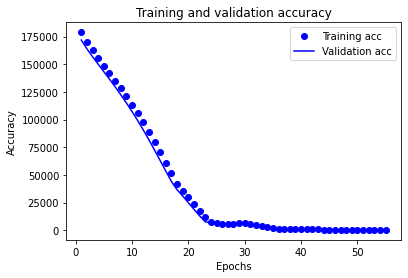

In [9]:
EPOCHS = 55
FOLDS = 4
FOLD_SIZE = len(train_data) // FOLDS
val_accs = []
total_val_acc = []
train_accs = []
total_train_acc = []
for k in range(FOLDS):    
    val_data = train_data.iloc[k * FOLD_SIZE: (k+1) * FOLD_SIZE]
    val_labels = train_labels.iloc[k * FOLD_SIZE: (k+1) * FOLD_SIZE]
    partial_train_data = pd.concat([train_data.iloc[: k * FOLD_SIZE] , train_data.iloc[(k+1) * FOLD_SIZE :]])
    partial_train_labels = pd.concat([train_labels.iloc[: k * FOLD_SIZE] , train_labels.iloc[(k+1) * FOLD_SIZE :]])
    val_data = normalise_preprocess(val_data.copy())
    partial_train_data = normalise_preprocess(partial_train_data.copy())
    
    assert pd.merge(partial_train_data, val_data, how='inner').shape[0] == 0     # sanity check to ensure no samples shared between validation set and training set

    model = build_model()

    history = model.fit(partial_train_data,
                        partial_train_labels,
                        epochs=EPOCHS,
                        batch_size=512,
                        validation_data=(val_data, val_labels),
                        verbose=1,
                        )

    history_dict = history.history

    train_accs.append(history_dict['mae'])
    val_accs.append(history_dict['val_mae'])

for e in range(len(val_accs[0])):
        valsum = 0
        trainsum = 0
        for k in range(FOLDS):
            valsum += val_accs[k][e]
            trainsum += train_accs[k][e]
        total_val = valsum / FOLDS
        total_train = trainsum / FOLDS
        total_val_acc.append(total_val)
        total_train_acc.append(total_train)
        
        
epochs = range(1, len(total_train_acc) + 1)

plt.plot(epochs, total_train_acc, 'bo', label='Training acc')
plt.plot(epochs, total_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()